In [73]:
from datasets import load_from_disk

ds = load_from_disk("./qa_dataset")

In [74]:
# ds =ds["train"].select(range(10)).to_pandas()
# ds.rename(columns={"query": "question", "generation_gt": "ground_truth"}, inplace=True)
# ds = ds[["question", "ground_truth"]]
# ds

In [75]:
from langchain_openai import ChatOpenAI
# from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
# from ragas.testset.generator import TestsetGenerator
# from ragas.testset.evolutions import simple, reasoning, multi_context
import nest_asyncio
nest_asyncio.apply()

llm = ChatOpenAI(openai_api_base="http://localhost:5000/v1", openai_api_key="lm-studio")
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/allenai-specter", model_kwargs={"device": "cpu"})

# generator = TestsetGenerator.from_langchain(
#     generator_llm=llm,
#     critic_llm=llm,
#     embeddings=emb,
# )

# testset = generator.generate_with_langchain_docs(chunks, test_size=1, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}, raise_exceptions=False)

d:\workspace\arxplore2\src\test_sub\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [76]:
from langchain_qdrant import QdrantVectorStore

def load_embedding():
    """Returns the embedding function based on the configuration."""
    return HuggingFaceEmbeddings(model_name="sentence-transformers/allenai-specter",
                                 model_kwargs={"device": "cpu"})

def load_vectorstore(qdrant_url:str, qdrant_api_key:str):
    """
    Initialize the retriever using the HuggingFace embeddings and Qdrant vectorstore.
    Returns:
        Retriever: A retriever for retrieving relevant documents.
    """
    embedding_function = load_embedding()

    vs = QdrantVectorStore.from_existing_collection(
        collection_name="arxiv_demo",
        embedding=embedding_function,
        url=qdrant_url,
        api_key=qdrant_api_key,
    )
    return vs

# db = FAISS.from_documents(chunks, emb)
QDRANT_API_KEY="N9eXayn-pnlZvbrZQU2cAZzchwaT6p1w7cs5KbZ9-zF00KamjGmmlA"
QDRANT_URL="https://1ed4f85b-722b-4080-97a7-afe8eab7ae7a.europe-west3-0.gcp.cloud.qdrant.io:6333"

vs = load_vectorstore(QDRANT_URL, QDRANT_API_KEY)
retriever = vs.as_retriever()

In [77]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [78]:
from langchain.chains import StuffDocumentsChain, LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_community.llms import OpenAI

# This controls how each document will be formatted. Specifically,
# it will be passed to `format_document` - see that function for more
# details.
document_prompt = PromptTemplate(
    input_variables=["page_content"],
    template="{page_content}"
)
document_variable_name = "context"
# The prompt here should take as an input variable the
# `document_variable_name`
llm_chain = LLMChain(llm=llm, prompt=prompt)
chain = StuffDocumentsChain(
    llm_chain=llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name
)

In [79]:
from datasets import Dataset

# Prepare the questions and ground truths
questions = ds["questions"]
ground_truth = ds["ground_truth"]
if isinstance(ground_truth[0], list):
    ground_truth = [gt[0] for gt in ground_truth]

# Initialize an empty data dictionary for the new dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

# Simulate RAG process: querying and retrieving documents
for query in questions:
    # Mock RAG chain and retriever responses (replace with actual RAG chain and retriever)
    # mock_answer = "This is a mock answer for query: " + query  # Simulate answer from RAG
    # mock_context = ["This is a context for the query: " + query]  # Simulate context from retriever
    docs = retriever.invoke(query, top_k=4)
    answer = chain.invoke({"question": query, "input_documents": docs})
    context = [doc.page_content for doc in docs]
    
    # Append the results to the data dictionary
    data["question"].append(query)
    data["answer"].append(answer["output_text"])
    data["contexts"].append(context)

# Create a dataset from the dictionary
dataset = Dataset.from_dict(data)

In [80]:
dataset = dataset.to_pandas()
dataset["ground_truth"] = [gt[0] for gt in dataset["ground_truth"]]
dataset

,question,answer,contexts,ground_truth
0,What is the time complexity of the merge sort ...,The context doesn't mention the merge sort alg...,"[Moreover, our algorithm runs in time ˜O(|Ω|k)...",O
1,How does a breadth-first search (BFS) traverse...,"Unfortunately, the given context does not ment...","[shortest path between two end points, and com...",I
2,What data structure is best suited for impleme...,The context provided does not mention anything...,"[understanding of these models is lacking, and...",S
3,"In Python, how do you define a function?",The provided context does not mention anything...,[the method is more generally applicable outsi...,U
4,What is the main difference between Java and C...,The provided context does not mention anything...,[munities.\n2012ACMSubjectClassification Compu...,J
...,...,...,...,...
66,How does the proposed method in the reinforcem...,"Unfortunately, the provided text snippet does ...",[1 Introduction\nReinforcement learning (RL) [...,T
67,What optimization techniques were used in the ...,The text does not explicitly mention specific ...,[variable weights) will produce loss functions...,A
68,What are the future research directions mentio...,The text does not explicitly mention specific ...,"[submitted to Vision, Modeling, and Visualizat...",F
69,What are the applications of the proposed mode...,"The text does not specifically mention a ""prop...",[∗Corresponding author\n©Bradley P. Allen and ...,T


In [82]:
import os
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
from ragas.run_config import RunConfig

run_config = RunConfig(max_workers=8, timeout=120)

os.environ["OPENAI_API_KEY"] = "test"
result = evaluate(
    dataset = Dataset.from_pandas(dataset),
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=llm,
    embeddings=emb,
)

Evaluating:   2%|▏         | 7/284 [02:45<1:23:12, 18.02s/it]Exception raised in Job[10]: TimeoutError()
Exception raised in Job[60]: TimeoutError()
Exception raised in Job[133]: TimeoutError()
Exception raised in Job[220]: TimeoutError()
Exception raised in Job[196]: TimeoutError()
Exception raised in Job[33]: TimeoutError()
Exception raised in Job[156]: TimeoutError()
Exception raised in Job[214]: TimeoutError()
Exception raised in Job[168]: TimeoutError()
Evaluating:   6%|▌         | 17/284 [03:36<29:18,  6.59s/it] Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Exception raised in Job[76]: TimeoutError()
Evaluating:   8%|▊         | 23/284 [04:38<35:44,  8.22s/it]Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to pa

In [86]:
df = result.to_pandas()

df

,question,contexts,answer,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,What is the time complexity of the merge sort ...,"[Moreover, our algorithm runs in time ˜O(|Ω|k)...",The context doesn't mention the merge sort alg...,O,NaN,NaN,NaN,NaN
1,How does a breadth-first search (BFS) traverse...,"[shortest path between two end points, and com...","Unfortunately, the given context does not ment...",I,NaN,NaN,NaN,NaN
2,What data structure is best suited for impleme...,"[understanding of these models is lacking, and...",The context provided does not mention anything...,S,NaN,NaN,NaN,0.983646
3,"In Python, how do you define a function?",[the method is more generally applicable outsi...,The provided context does not mention anything...,U,NaN,NaN,NaN,NaN
4,What is the main difference between Java and C...,[munities.\n2012ACMSubjectClassification Compu...,The provided context does not mention anything...,J,NaN,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...
66,How does the proposed method in the reinforcem...,[1 Introduction\nReinforcement learning (RL) [...,"Unfortunately, the provided text snippet does ...",T,NaN,NaN,NaN,0.000000
67,What optimization techniques were used in the ...,[variable weights) will produce loss functions...,The text does not explicitly mention specific ...,A,NaN,NaN,NaN,0.000000
68,What are the future research directions mentio...,"[submitted to Vision, Modeling, and Visualizat...",The text does not explicitly mention specific ...,F,NaN,NaN,NaN,0.820557
69,What are the applications of the proposed mode...,[∗Corresponding author\n©Bradley P. Allen and ...,"The text does not specifically mention a ""prop...",T,NaN,NaN,NaN,NaN


In [71]:
df.isnull().sum()

question              0
contexts              0
answer                0
ground_truth          0
context_precision    71
context_recall       47
faithfulness         70
answer_relevancy     46
dtype: int64

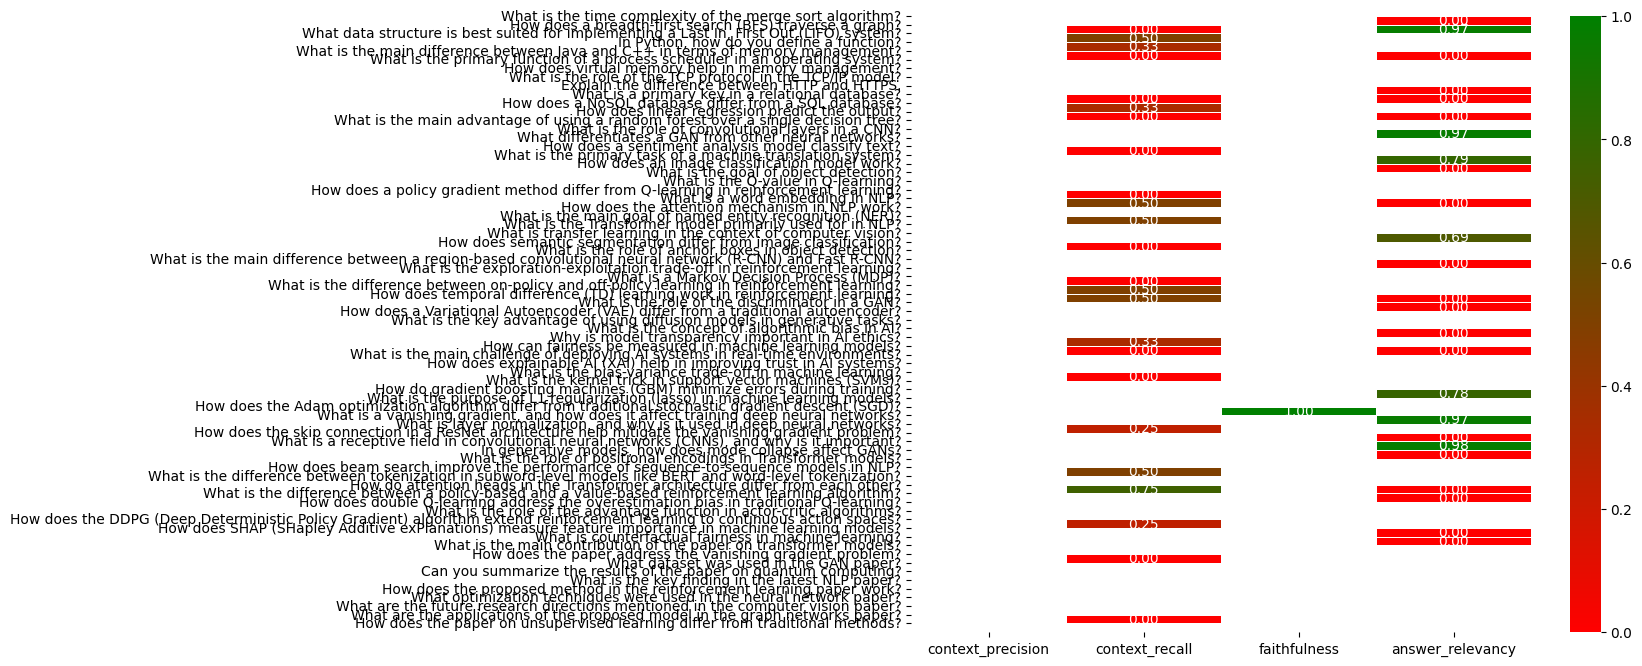

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()


### Add LangFuse

In [ ]:
from langfuse import Langfuse

langfuse = Langfuse(
  secret_key="sk-lf-8be80c67-4187-4e43-9d01-544195dc9f03",
  public_key="pk-lf-d7653f64-8086-4365-b05c-865ead3478a3",
  host="http://localhost:3000"
)

In [ ]:
trace = langfuse.trace(
    name = "eval",
    user_id = "eval_user",
    metadata = {
        "email": "prod@company.com",
    },
    tags = ["evaluation"]
)

In [ ]:
df = result.to_pandas()

In [ ]:
for _, row in df.iterrows():
    for metric_name in ["faithfulness", "answer_relevancy", "context_recall"]:
        langfuse.score(
            name=metric_name,
            value=row[metric_name],
            trace_id=trace.id
        )